# Initial hyperparameter tuning on gender classification in facial images: <br> Number of nodes in FC$_1$ layer

Here, a single task learning based (STL) model is used to classify facial images of UTKFace data based on gender and identify the optimal number of nodes for the fully connecetd (FC$_1$) layer.  <br>

Model: VGG16 base (fully frozen) + [FC$_1$ with x nodes] + out  <br>
where x = [32, 64, 128, 256]  <br>

In this experiment, optimal number of nodes in FC$_1$ is found through a grid search on [32, 64, 128, 256] and choosing best value that gives the highest validation accuracy on the VGG based models used to classify gender from a sample of UTKFace data. In this experiment, a small data sample is used to minimize extended training times that would have occurred if the entire dataset had been used.

The following shows the required imports to run this colab file.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import cv2
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses
from keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import set_random_seed
from keras.utils import plot_model
from tensorflow import keras
from tensorflow.keras.callbacks import Callback

Now, the seed is set to a random integer so that same sequence of random numbers are generated each time the programme is run. Therefore, this ensures that the results are reproducible.

In [ ]:
# Setting the seed
seed = 42
set_random_seed(seed)
np.random.seed(42)

Here, my Google Drive is connected to this Colab file.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Below folder contains the cropped faces of the UTKFace data (Song, Zhang and Qi, 2017) from the "RetinaFace" algorithm (Deng et al., 2020). This deep learning based algorithm was used to extract faces with a fixed spatial resolution of 100 x 100 and save them in RGB image form.

In [ ]:
folder_path = "/content/drive/My Drive/UTKFace_retina_cropped_100x100"

Following shows the total number of facial images stored in the folder.

In [ ]:
cnt = 0
for file in sorted(os.listdir(folder_path)):  # Sort file list
  file_path = os.path.join(folder_path,file)
  cnt = cnt + 1

print(f"Number of face images: {cnt}")

Number of face images: 23561


The following code creates a bar chart showing the gender counts in the UTKFace dataset used in this study.

Text(0.5, 1.0, 'Distribution of gender in the UTKFace dataset')

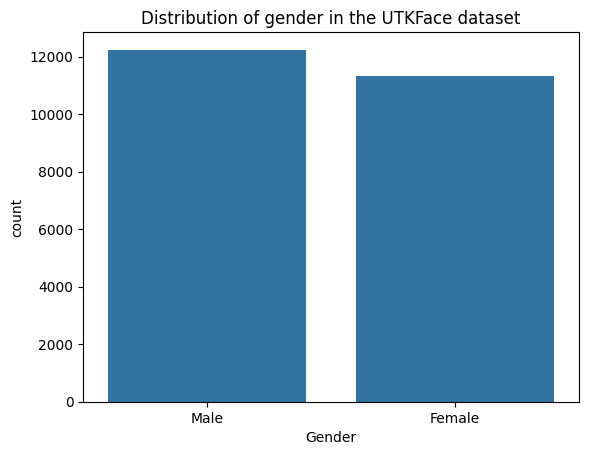

In [ ]:
# age: is an integer from 0 to 116, indicating the age
# gender: is either 0 (male) or 1 (female)
# race: is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

column_names = ['Age', 'Gender', 'Race']
records = []

for file in os.listdir(folder_path):
  records.append(file.split('_')[:-1])

DFrame=pd.DataFrame(records, columns=column_names).astype(int)

gender_mapping = {
    0: 'Male',
    1: 'Female'
}

# Replace the integers with correct gender
DFrame['Gender'] = DFrame['Gender'].replace(gender_mapping)

# Count plot
plt.figure()
sns.countplot(x='Gender', data=DFrame)
plt.title('Distribution of gender in the UTKFace dataset')

In [ ]:
def read_image(fname):
    # Extracting label from file name
    parts = tf.strings.split(fname, os.sep)
    file_name = parts[-1]
    multiple_labels = tf.strings.split(file_name, '_')

    # Extracting labels
    gender_label = tf.strings.to_number(multiple_labels[1], out_type=tf.int32)     # Second part: gender

    # Loading and decoding the image
    image = tf.io.read_file(fname)
    image = tf.io.decode_jpeg(image)
    return image, gender_label

In [ ]:
def preprocess_image(image, gender_label):
    # Converting image to float32 and normalize to [0,1]
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, gender_label

This below code splits a dataset of file paths into 10% for training and 5% for validation using TensorFlow's tf.data.Dataset API. It starts by listing all files in a specified folder and shuffling them for randomness with a fixed seed for reproducibility. The dataset is then divided according to the above mentioned percentages.

In [ ]:
# Creating training, validation and test sets.
list_ds = tf.data.Dataset.list_files(folder_path + "/*")

# Total number of files
file_count = len(list_ds)

# Defining split sizes
train_size = int(0.1 * file_count)  # 10% for training
val_size = int(0.05 * file_count)    # 5% for validation

# Shuffling the dataset before splitting
list_ds = list_ds.shuffle(buffer_size=file_count, seed=42)

# Splitting into training, validation, and test datasets
train_list_ds = list_ds.take(train_size)  # First 10% for training
val_list_ds = list_ds.skip(train_size).take(val_size)  # Next 5% for validation

The below code processes training and validation datasets. Each dataset is prepared by mapping file paths to images using read_image, followed by applying preprocessing with preprocess_image. The datasets are batched with a size of 128, cached for faster reuse, and prefetched to improve performance by preparing the next batch while the current one is being processed. The use of tf.data.AUTOTUNE optimizes parallelism and performance.

In [ ]:
batch_size = 128

# Updated dataset preparation with preprocessing
train_ds = (
    train_list_ds
    .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, gender_lbl:
         preprocess_image(img, gender_lbl),  # Applying preprocessing
         num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    val_list_ds
    .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, gender_lbl:
         preprocess_image(img, gender_lbl),  # Applying preprocessing
         num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

The following code shows the shape of the images in the first batch and all gender labels of images in the first batch.

In [ ]:
# Sample check
for img, labels in train_ds.take(1):  # Take one batch
    print("Image shape:", img.shape)  # Print image shape
    # Accessing individual labels
    print("Gender labels:", labels.numpy())


Image shape: (128, 100, 100, 3)
Gender labels: [0 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 1
 1 0 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 1 1 0 1 0 1 1 0 1
 0 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 0 0 0 1 0 0 0
 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0]


The following code shows the first image of the first batch along with the labels as an example image in the training data.

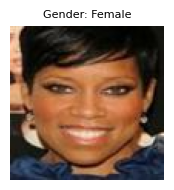

Gender Label: Female, Gender Integer: 1


In [ ]:
# Defining label names for the tasks
gender_labels = ["Male", "Female"]

img_no = 0

# Looping through the dataset to extract and visualising one example image
for img, labels in train_ds.take(1):
    img0 = img[img_no]
    gender_label = gender_labels[labels[img_no]]

    # Displaying the image with the labels
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.imshow(img0)
    ax.axis('off')
    ax.set_title(f"Gender: {gender_label}", fontsize=8)
    plt.show()

    # Printing detailed information
    print(f"Gender Label: {gender_label}, Gender Integer: {labels[img_no]}")

    img_no = img_no + 1
    if img_no == batch_size:
       img_no = 0
    # Breaking after first example
    break

## 2. Building a CNN using Transfer Learning on VGG16
Input image shape: (100, 100, 3)

The following code defines different deep learning models for gender classification. The input is an image of shape (100, 100, 3). It begins by creating a convolutional neural network (CNN) based on a modified VGG16 architecture. This model has a VGG16 convolutional base with five blocks, each containing multiple convolutional layers followed by max-pooling to progressively extract spatial features while reducing dimensionality. Pre-trained weights from ImageNet are loaded into this base model to leverage learned representations. All layers in the base model are frozen apart from the 5th block to allow the model to fine-tune on UTKFace data. Then a fully connected layer (FC1) is attached along with an output layer. Here, different numbers of nodes in FC1, such as 32, 64, 128, or 256 for the same network are used to identify which number of nodes creates a network with higher validation accuracy for gender classification.

In [ ]:
from tensorflow.keras.applications import vgg16
FC1= [32, 64, 128, 256]
gender_loss = []
gender_val_loss = []
gender_accuracy = []
gender_val_accuracy = []
evaluation_results = []
trainable_params = []
non_trainable_params = []
total_params = []

# Load the vgg16 model with pre-trained ImageNet weights and without the top classification layer
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Preloading datasets by iterating through them once
print("Preloading training dataset...")
for _ in train_ds:
    pass  # This ensures the entire training dataset is cached
print("Preloading validation dataset...")
for _ in val_ds:
    pass  # This ensures the entire validation dataset is cached
print("Datasets preloaded successfully!")

for nodes in FC1:
  seed = 42
  set_random_seed(seed)
  np.random.seed(42)
  img_input = layers.Input((100, 100, 3), dtype='float32', name='base_model')

  # Clone the base model
  cl_base = models.clone_model(base_model)
  cl_base.set_weights(base_model.get_weights())

  for layer in cl_base.layers:
    layer.trainable = False

  # Gender Classification
  gender_vec = layers.GlobalAveragePooling2D()(cl_base.output)
  gender = layers.Dense(nodes, activation='relu', name='gender_fc1')(gender_vec)
  gender_out = layers.Dense(2, activation='softmax', name='gender_output')(gender)

  # Single-task Model
  model = models.Model(inputs=cl_base.input, outputs=[gender_out], name=f'st_model_fc1_{nodes}')

  # Creating the checkpoint callback
  checkpoint_path = '/content/checkpoint/weights.keras'
  mc_callback = ModelCheckpoint(filepath=checkpoint_path,
                                monitor='val_accuracy',
                                save_best_only=True,
                                mode='max')

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])

  print(f"Training a VGG model with FC1={nodes} nodes")
  history = model.fit(
                      train_ds,
                      epochs=10,
                      validation_data=val_ds,
                      batch_size=batch_size,
                      callbacks=[mc_callback]
                     )
  # My model’s last layer has a softmax activation, thus from_logits=False

  gender_loss.append(history.history['loss'])
  gender_val_loss.append(history.history['val_loss'])
  gender_accuracy.append(history.history['accuracy'])
  gender_val_accuracy.append(history.history['val_accuracy'])

  # Loading the weights of the model with the best validation accuracy
  model.load_weights(checkpoint_path)

  # Evaluating the model on the test dataset
  evaluation_results.append(model.evaluate(val_ds, verbose=2))

  # Get trainable and non-trainable parameters
  trainable_params.append(np.sum([np.prod(w.shape) for w in model.trainable_weights]))
  non_trainable_params.append(np.sum([np.prod(w.shape) for w in model.non_trainable_weights]))
  total_params.append(model.count_params())

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Preloading training dataset...
Preloading validation dataset...
Datasets preloaded successfully!
Training a VGG model with FC1=32 nodes
Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 732ms/step - accuracy: 0.4978 - loss: 0.7337 - val_accuracy: 0.5832 - val_loss: 0.6789
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.5985 - loss: 0.6714 - val_accuracy: 0.6138 - val_loss: 0.6635
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.6493 - loss: 0.6570 - val_accuracy: 0.6689 - val_loss: 0.6470
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.7050 - loss: 0.6431 - val_accuracy: 0.7020 - val_loss: 0.6335
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.7278 - loss: 0.6311 - val_accuracy: 0.7275 - val_loss: 0.6206
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.7428 - loss: 0.6196 - val_accuracy: 0.7462 - val_loss: 0.6079
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 171

**The following plot shows the training and validation losses and accuracies of models with FC$_1$ layers with different number of nodes.**

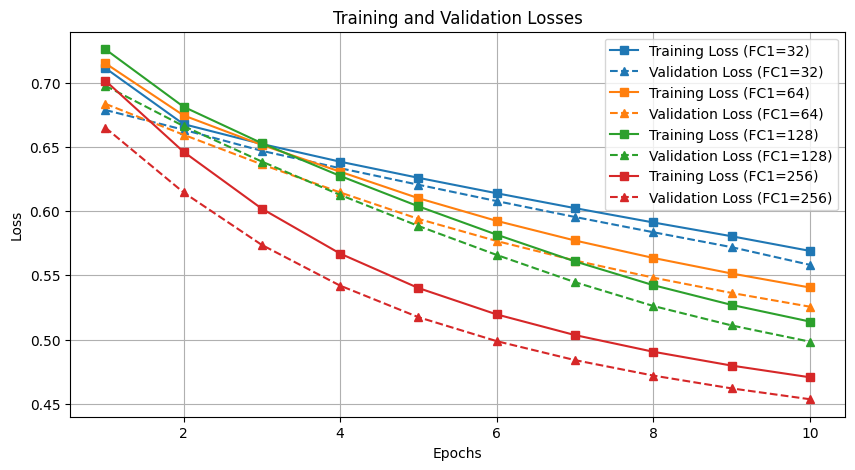

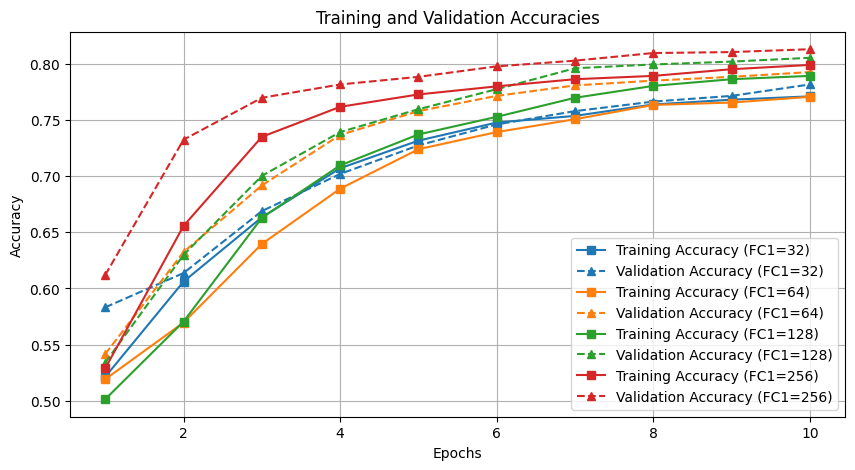

In [ ]:
# FC1 values
FC1 = [32, 64, 128, 256]
Epochs = np.arange(1,11)
colours = plt.cm.tab10(range(len(FC1)))   #colormap

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
for i, nodes in enumerate(FC1):
  plt.plot(Epochs, gender_loss[i], color=colours[i], marker='s', label=f'Training Loss (FC1={nodes})')
  plt.plot(Epochs, gender_val_loss[i], color=colours[i], marker='^', linestyle='--', label=f'Validation Loss (FC1={nodes})')

plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
for i, nodes in enumerate(FC1):
  plt.plot(Epochs, gender_accuracy[i], color=colours[i], marker = 's', label=f'Training Accuracy (FC1={nodes})')
  plt.plot(Epochs, gender_val_accuracy[i], color=colours[i], marker= '^', linestyle='--', label=f'Validation Accuracy (FC1={nodes})')

plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()



**The following code creates a table with FC$_1$ nodes, trainable parameters in each model and the validation accuracy of each model.**

In [ ]:
# Trainable Parameters:
FC1 = [32, 64, 128, 256]
best_val_accuracy = np.round(np.max(np.array(gender_val_accuracy), axis=1), 2)
dframe = pd.DataFrame({'FC1 nodes':FC1,
                       'Trainable Parameters':trainable_params, 'Validation Accuracy:':best_val_accuracy})
print(dframe.to_string(index=False))

 FC1 nodes  Trainable Parameters  Validation Accuracy:
        32                 16482                  0.78
        64                 32962                  0.79
       128                 65922                  0.81
       256                131842                  0.81


In [ ]:
np.max(np.array(gender_val_accuracy), axis=1)

array([0.78183359, 0.79286927, 0.80560273, 0.81324279])

In [ ]:
# Non-trainable Parameters:
FC1 = [32, 64, 128, 256]
dframe = pd.DataFrame({'FC1 nodes':FC1,
                       'Non-trainable Parameters':non_trainable_params})
print(dframe.to_string(index=False))

 FC1 nodes  Non-trainable Parameters
        32                  14714688
        64                  14714688
       128                  14714688
       256                  14714688


In [ ]:
# Total Parameters:
FC1 = [32, 64, 128, 256]
dframe = pd.DataFrame({'FC1 nodes':FC1,
                       'Total Parameters':total_params})
print(dframe.to_string(index=False))

 FC1 nodes  Total Parameters
        32          14731170
        64          14747650
       128          14780610
       256          14846530


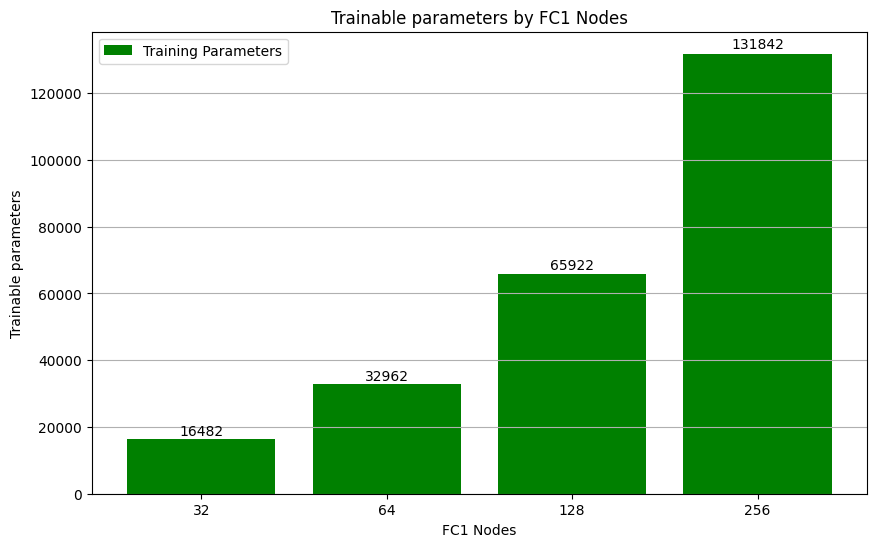

In [ ]:
# 2. Bar Chart for Total Parameters
FC1 = [32, 64, 128, 256]
x = np.arange(len(FC1))

plt.figure(figsize=(10, 6))
trainable_params_size = np.array(trainable_params)
bars = plt.bar(x, trainable_params_size, color='green', label='Training Parameters')
plt.title('Trainable parameters by FC1 Nodes')
plt.xlabel('FC1 Nodes')
plt.ylabel('Trainable parameters')

for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x()+bar.get_width()/2, yval+yval*0.005, f'{int(yval)}', ha='center', va='bottom')

plt.xticks(x, FC1)  # Set x-axis labels as FC1 values
plt.legend()
plt.grid(axis='y')
plt.show()

**Below section was run later to fix the titles and prepare plots to use in the report. Values are extracted from the output of previous cells.**

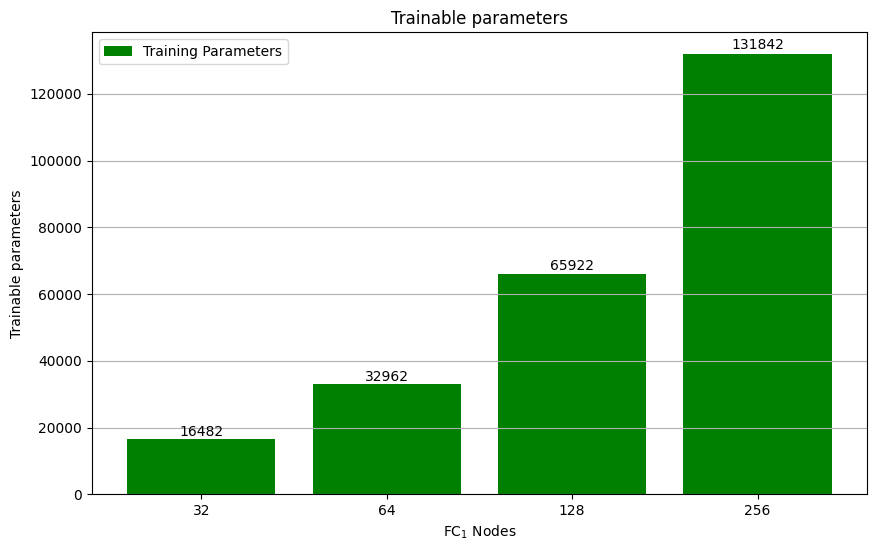

In [6]:
import numpy as np
import matplotlib.pyplot as plt

 # Fixing the title of the above plot. (This section was run later)

trainable_params = [16482, 32962, 65922, 131842]  # Extracted from the above cell output
#Validation_accuracy= [0.78, 0.79, 0.81, 0.81]

FC1 = [32, 64, 128, 256]
x = np.arange(len(FC1))

plt.figure(figsize=(10, 6))
trainable_params_size = np.array(trainable_params)
bars = plt.bar(x, trainable_params_size, color='green', label='Training Parameters')
plt.title('Trainable parameters')
plt.xlabel('FC$_1$ Nodes')
plt.ylabel('Trainable parameters')

for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x()+bar.get_width()/2, yval+yval*0.005, f'{int(yval)}', ha='center', va='bottom')

plt.xticks(x, FC1)  # Set x-axis labels as FC1 values
plt.legend()
plt.grid(axis='y')
plt.show()